# Package

In [1]:
import time
import os
from copy import deepcopy 

import tensorflow as tf
from tensorflow.contrib import rnn

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle, resample
from sklearn.model_selection import KFold

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print("Package is ready.")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Package is ready.


In [2]:
matplotlib.rcParams['figure.figsize'] = (20, 15)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293", "#6bbcb3"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442", "#1ca597"]

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

# Hyperparameters

In [3]:
N_FOLD = 5
EX_PRED = 10000

# Data Preparation

## loading

In [4]:
# Load data
l = np.load("./data/Allenv_MT-LN-LSTM_T144_I10 min.npz")

# See what's in here
print (l.files)

# get data
rnn_input = l["inputs"]
rnn_label = l["labels"]

MINS = l["mins"]
MAXS = l["maxs"]

LABELMINS = l["labelmins"]
LABELMAXS = l["labelmaxs"]

TIME_STEPS = int(l["timesteps"])
OUTPUT_SIZE = int(l["outputsize"])

START_OUTPUT = pd.DatetimeIndex(l["start_output"])
START_INPUT = pd.DatetimeIndex(l["start_input"])
END_OUTPUT = pd.DatetimeIndex(l["end_output"])
END_INPUT = pd.DatetimeIndex(l["end_input"])
INTERVAL = pd.Timedelta(str(l["interval"]))

#EXPLANATION = str(l["explanation"])
EXPLANATION = "Allenv_altMT-LN-LSTM" + "_T" + str(TIME_STEPS) + "_I" + str(l["interval"])

['labelmins', 'interval', 'maxs', 'start_output', 'start_input', 'labelmaxs', 'labels', 'outputsize', 'explanation', 'end_input', 'end_output', 'inputs', 'mins', 'timesteps']


In [5]:
EXPLANATION

'Allenv_altMT-LN-LSTM_T144_I10 min'

In [6]:
N_TASKS = 6

## Separating

In [7]:
print("time steps: %d, " % TIME_STEPS, end="")
print("output size: %d" % OUTPUT_SIZE)
print("Number of data: %d" % len(rnn_label))
print("Number of input: %d" % rnn_input[0].shape[1])

time steps: 144, output size: 12
Number of data: 87252
Number of input: 15


In [8]:
N_DATA = len(rnn_label)
RATIO = 0.3
N_TEST = int(np.trunc(N_DATA*RATIO))
FOLD_INTERVAL = int(np.trunc((N_DATA - N_TEST)/(N_FOLD - 1)))

print("%d-fold validation setting" % N_FOLD)
print("Test ratio: %.2f\nNumber of test: %d\nFolding interval: %d" % (RATIO, N_TEST, FOLD_INTERVAL))

5-fold validation setting
Test ratio: 0.30
Number of test: 26175
Folding interval: 15269


In [9]:
pred_indexs = []
    
for i in range(N_FOLD):
    pred_indexs.append(FOLD_INTERVAL*i)

In [10]:
pred_inputs = []
pred_labels = []
rnn_inputs = []
rnn_labels = []

pred_input_index = []
pred_label_index = []

i = 0

for pred_index in pred_indexs[:-1]:
    pred_input = rnn_input[pred_index:pred_index+N_TEST, :, :]
    pred_input_index.append(START_INPUT[pred_index:pred_index+N_TEST])
    
    pred_label = rnn_label[pred_index:pred_index+N_TEST, :]
    pred_label_index.append(START_OUTPUT[pred_index:pred_index+N_TEST])
    
    pred_inputs.append(pred_input)
    pred_labels.append(pred_label)

    rnn_inputs.append(rnn_input)
    rnn_labels.append(rnn_label)
    rnn_inputs[i] = np.delete(rnn_inputs[i], [i for i in range(pred_index, pred_index+N_TEST+OUTPUT_SIZE)], axis=0)
    rnn_labels[i] = np.delete(rnn_labels[i], [i for i in range(pred_index, pred_index+N_TEST+OUTPUT_SIZE)], axis=0)
    i += 1

pred_index = pred_indexs[-1]
pred_input = rnn_input[pred_index:pred_index+N_TEST, :, :]
pred_input_index.append(START_INPUT[pred_index:pred_index+N_TEST])

pred_label = rnn_label[pred_index:pred_index+N_TEST, :]
pred_label_index.append(START_OUTPUT[pred_index:pred_index+N_TEST])

pred_inputs.append(pred_input)
pred_labels.append(pred_label)

rnn_inputs.append(rnn_input)
rnn_labels.append(rnn_label)
rnn_inputs[-1] = rnn_inputs[-1][:pred_index]
rnn_labels[-1] = rnn_labels[-1][:pred_index]

In [11]:
for i in range(N_FOLD):
    rnn_inputs[i], rnn_labels[i] = shuffle(rnn_inputs[i], rnn_labels[i])

In [12]:
pred_inputs[0].shape

(26175, 144, 15)

In [13]:
pred_labels[0].shape

(26175, 12, 6)

In [14]:
print("Data is ready.")

Data is ready.


# Training & Plotting

In [15]:
def FC(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, activation_fn=None, scope=scope)

def BN_FC(x, n_hidden, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, n_hidden, activation_fn=None, scope='FC')
        h2 = tf.layers.batch_normalization(h1, training=phase)
        return tf.nn.relu(h2, 'relu')

In [16]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

1-fold started.
Epoch:        0/   50000 cost: 6.790278, best: 100000.000
Training Acc: -23.568, Test Acc: -19.893
-145.338 -39.825 -306.446 -113.755 -15.544 -91.350 
-118.70954591985628
Epoch:      500/   50000 cost: 0.016290, best: 100000.000
Training Acc: 0.929, Test Acc: 0.937
0.809 0.652 0.106 0.706 0.957 0.390 
0.6032180449197481
Epoch:     1000/   50000 cost: 0.013215, best: 100000.000
Training Acc: 0.959, Test Acc: 0.960
0.890 0.740 0.424 0.537 0.979 0.874 
0.7406611983091476
Epoch:     1003/   50000 cost: 0.011737, best: 0.022 *Best value was replaced.
0.890 0.740 0.424 0.537 0.979 0.874 
0.7406611983091476
Epoch:     1004/   50000 cost: 0.014298, best: 0.019 *Best value was replaced.
0.890 0.740 0.424 0.537 0.979 0.874 
0.7406611983091476
Epoch:     1019/   50000 cost: 0.013541, best: 0.018 *Best value was replaced.
0.890 0.740 0.424 0.537 0.979 0.874 
0.7406611983091476
Epoch:     1020/   50000 cost: 0.012126, best: 0.015 *Best value was replaced.
0.890 0.740 0.424 0.537 0.9

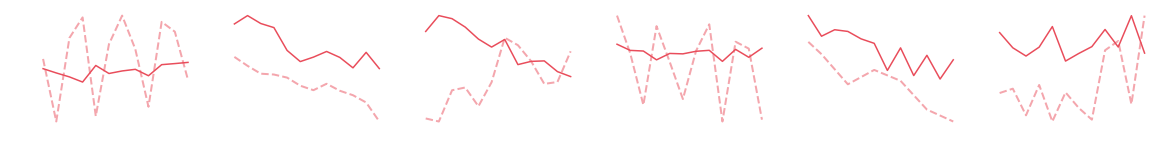

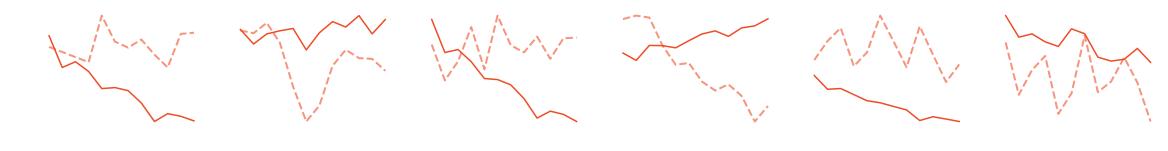

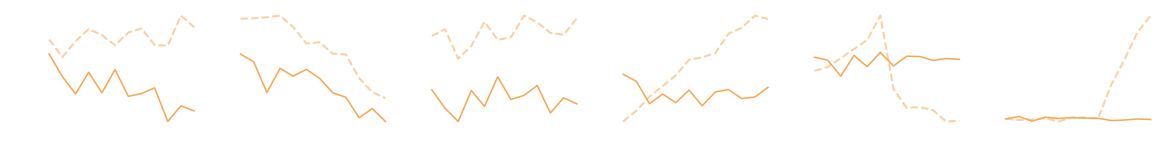

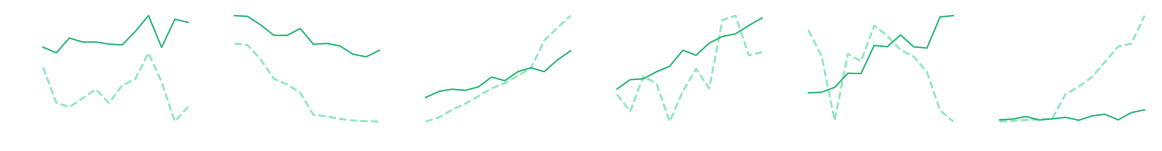

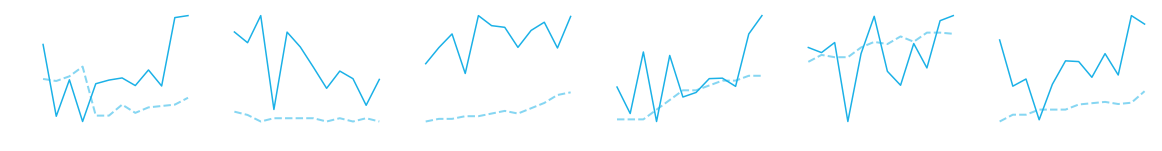

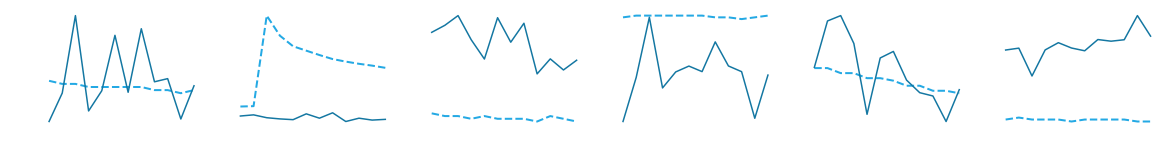

2-fold started.
Epoch:        0/   50000 cost: 7.249282, best: 100000.000
Training Acc: -42.049, Test Acc: -40.905
-197.970 -220.938 -591.438 -52.949 -7.942 -12.116 
-180.55894693994887
Epoch:      500/   50000 cost: 0.015950, best: 100000.000
Training Acc: 0.622, Test Acc: 0.656
0.774 0.691 -0.359 0.731 -0.142 0.157 
0.30855343635703825
Epoch:     1000/   50000 cost: 0.013809, best: 100000.000
Training Acc: 0.904, Test Acc: 0.896
0.897 0.446 -0.275 0.712 0.964 0.759 
0.5839764107297882
Epoch:     1003/   50000 cost: 0.012757, best: 0.033 *Best value was replaced.
0.897 0.446 -0.275 0.712 0.964 0.759 
0.5839764107297882
Epoch:     1007/   50000 cost: 0.012934, best: 0.027 *Best value was replaced.
0.897 0.446 -0.275 0.712 0.964 0.759 
0.5839764107297882
Epoch:     1024/   50000 cost: 0.011759, best: 0.026 *Best value was replaced.
0.897 0.446 -0.275 0.712 0.964 0.759 
0.5839764107297882
Epoch:     1030/   50000 cost: 0.013484, best: 0.024 *Best value was replaced.
0.897 0.446 -0.275 0.

Epoch:    15000/   50000 cost: 0.006105, best: 0.012
Training Acc: 0.980, Test Acc: 0.961
0.927 0.848 0.681 0.839 0.980 0.953 
0.87122245198679
Epoch:    15500/   50000 cost: 0.004196, best: 0.012
Training Acc: 0.988, Test Acc: 0.966
0.932 0.867 0.752 0.812 0.998 0.968 
0.8881111254476396
Epoch:    16000/   50000 cost: 0.004977, best: 0.012
Training Acc: 0.987, Test Acc: 0.963
0.925 0.846 0.715 0.831 0.998 0.949 
0.8770887483262346
Epoch:    16500/   50000 cost: 0.004008, best: 0.012
Training Acc: 0.986, Test Acc: 0.962
0.932 0.850 0.734 0.807 0.998 0.938 
0.8765170448904518
Epoch:    17000/   50000 cost: 0.005265, best: 0.012
Training Acc: 0.985, Test Acc: 0.960
0.897 0.831 0.746 0.815 0.998 0.954 
0.8735406291321338
Epoch:    17500/   50000 cost: 0.004348, best: 0.012
Training Acc: 0.988, Test Acc: 0.962
0.928 0.840 0.730 0.792 0.998 0.967 
0.8757407557573047

Early stopping.
Epoch:    17837/   50000 cost: 0.004703, best: 0.012
Training Acc: 0.984, Test Acc: 0.957
Optimization Finish

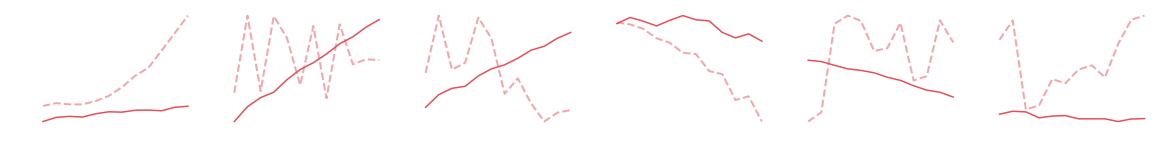

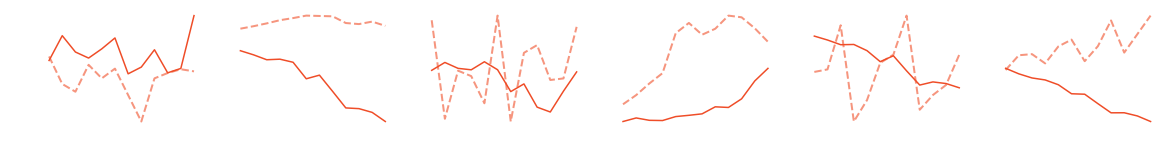

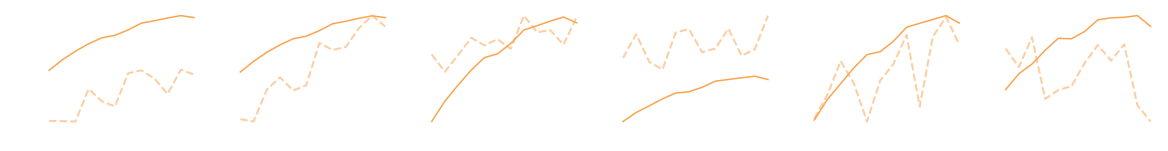

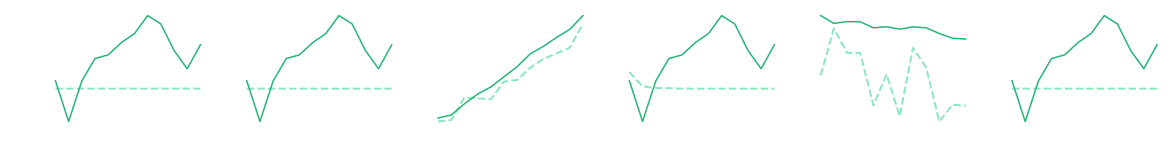

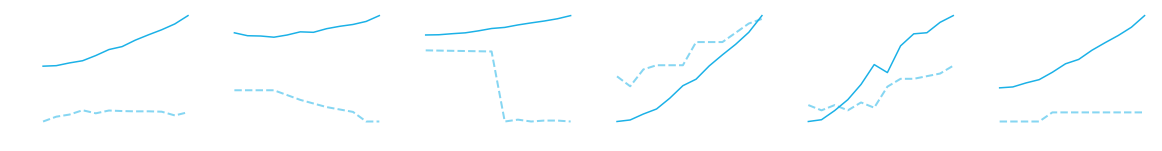

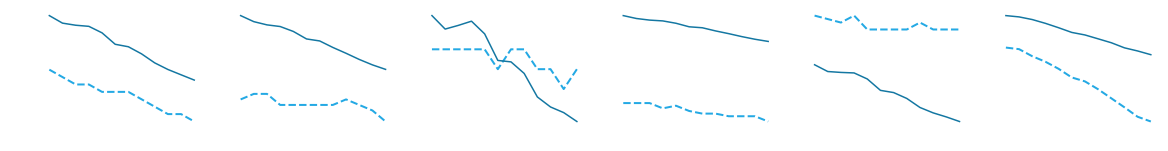

3-fold started.
Epoch:        0/   50000 cost: 6.693336, best: 100000.000
Training Acc: -14.708, Test Acc: -13.557
-474.614 -32.545 -183.302 -10.428 -65.476 -21.790 
-131.35918969639206
Epoch:      500/   50000 cost: 0.011616, best: 100000.000
Training Acc: 0.947, Test Acc: 0.907
0.369 0.716 -0.171 0.702 -0.373 0.839 
0.3471778657759316
Epoch:     1000/   50000 cost: 0.010656, best: 100000.000
Training Acc: 0.941, Test Acc: 0.911
0.354 0.723 0.583 0.697 -0.056 0.713 
0.5022898081334961
Epoch:     1002/   50000 cost: 0.011970, best: 0.030 *Best value was replaced.
0.354 0.723 0.583 0.697 -0.056 0.713 
0.5022898081334961
Epoch:     1036/   50000 cost: 0.011468, best: 0.029 *Best value was replaced.
0.354 0.723 0.583 0.697 -0.056 0.713 
0.5022898081334961
Epoch:     1110/   50000 cost: 0.010748, best: 0.026 *Best value was replaced.
0.354 0.723 0.583 0.697 -0.056 0.713 
0.5022898081334961
Epoch:     1410/   50000 cost: 0.008659, best: 0.026 *Best value was replaced.
0.354 0.723 0.583 0.69

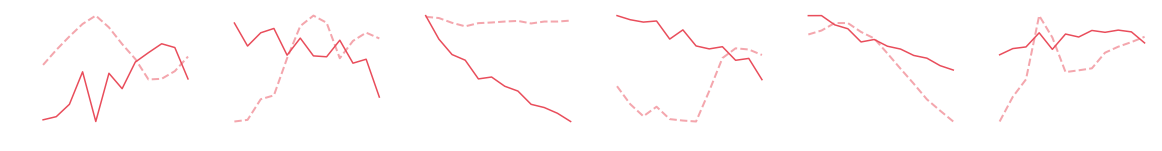

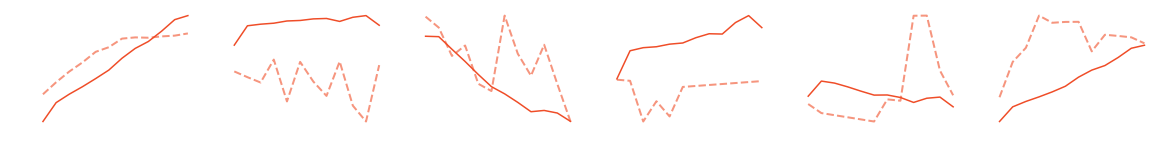

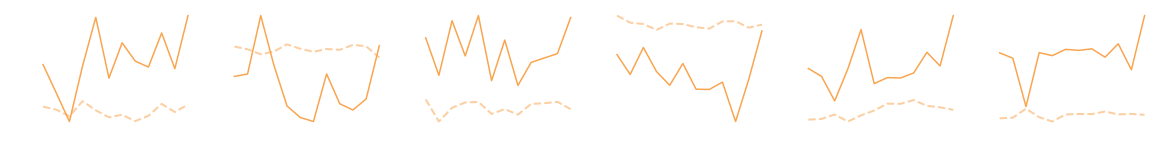

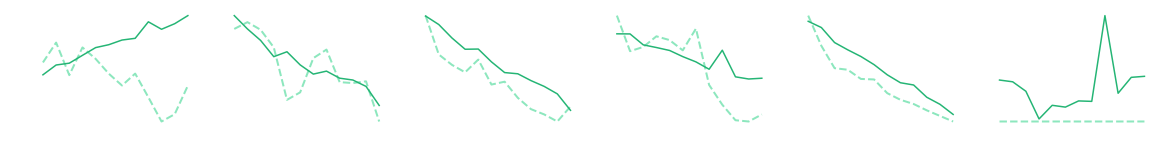

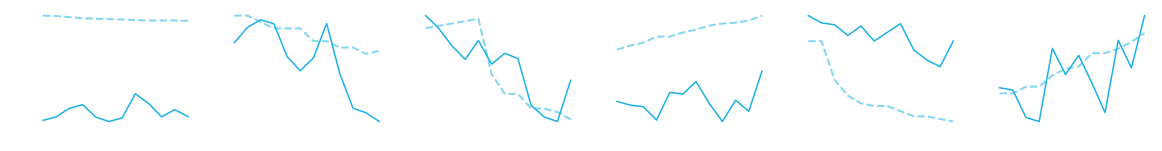

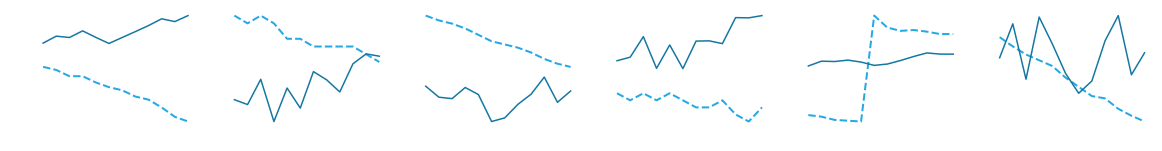

4-fold started.
Epoch:        0/   50000 cost: 7.156056, best: 100000.000
Training Acc: -19.233, Test Acc: -22.648
-515.511 -34.778 -224.330 -53.848 -57.928 -18.910 
-150.8841839338424
Epoch:      500/   50000 cost: 0.016926, best: 100000.000
Training Acc: 0.937, Test Acc: 0.916
0.512 0.878 0.400 0.741 0.917 0.576 
0.6706683729873525
Epoch:     1000/   50000 cost: 0.012015, best: 100000.000
Training Acc: 0.930, Test Acc: 0.920
0.719 0.865 -0.938 0.686 0.605 0.821 
0.4595068177321864
Epoch:     1002/   50000 cost: 0.011038, best: 0.020 *Best value was replaced.
0.719 0.865 -0.938 0.686 0.605 0.821 
0.4595068177321864
Epoch:     1015/   50000 cost: 0.013003, best: 0.020 *Best value was replaced.
0.719 0.865 -0.938 0.686 0.605 0.821 
0.4595068177321864
Epoch:     1042/   50000 cost: 0.012788, best: 0.015 *Best value was replaced.
0.719 0.865 -0.938 0.686 0.605 0.821 
0.4595068177321864
Epoch:     1065/   50000 cost: 0.014679, best: 0.013 *Best value was replaced.
0.719 0.865 -0.938 0.686 

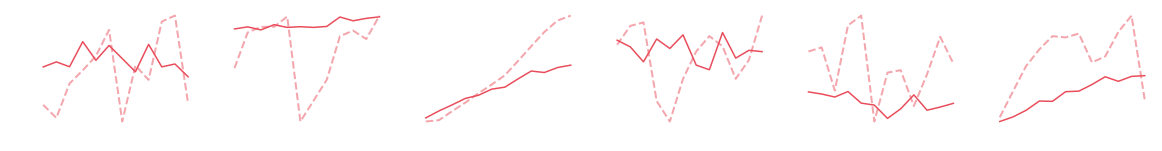

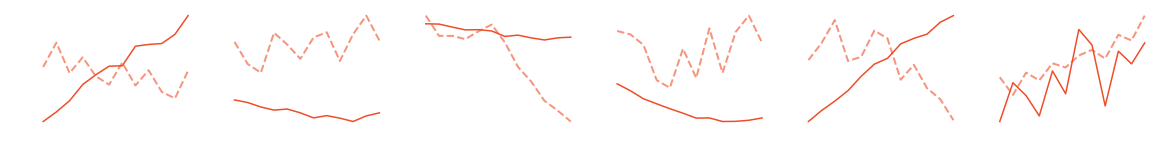

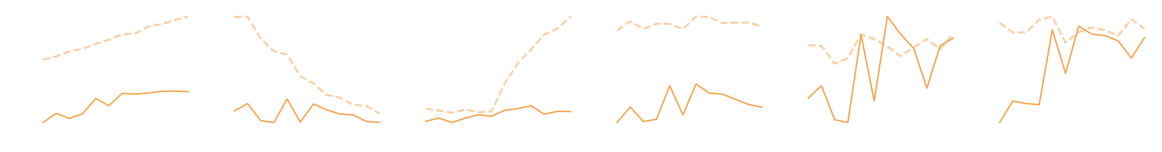

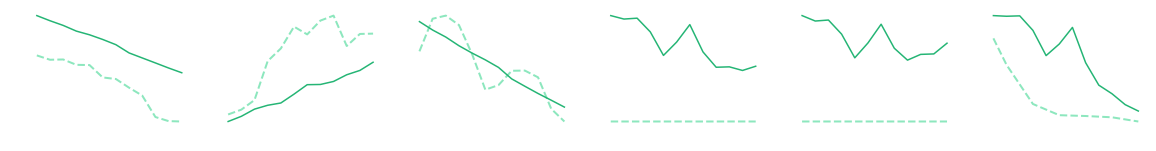

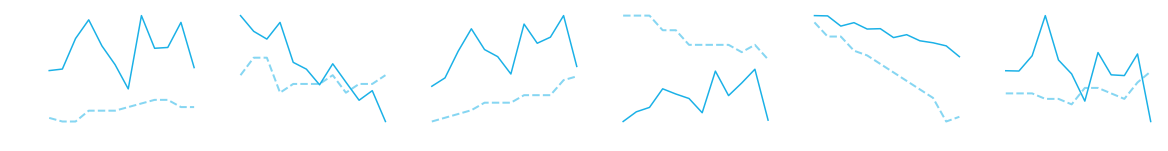

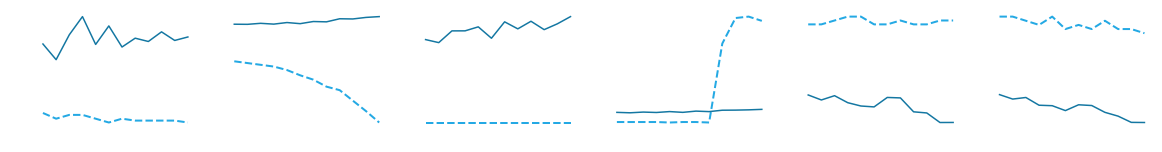

5-fold started.
Epoch:        0/   50000 cost: 6.695250, best: 100000.000
Training Acc: -9.531, Test Acc: -13.586
-66.609 -27.717 -604.848 -25.747 -20.417 -13.266 
-126.43391090039455
Epoch:      500/   50000 cost: 0.018627, best: 100000.000
Training Acc: 0.907, Test Acc: 0.812
0.652 0.715 -7.517 0.631 0.735 0.662 
-0.6871470104747046
Epoch:     1000/   50000 cost: 0.011781, best: 100000.000
Training Acc: 0.849, Test Acc: 0.752
0.611 -0.446 -1.562 0.480 0.345 0.930 
0.059818297813666224
Epoch:     1002/   50000 cost: 0.012548, best: 0.073 *Best value was replaced.
0.611 -0.446 -1.562 0.480 0.345 0.930 
0.059818297813666224
Epoch:     1003/   50000 cost: 0.011841, best: 0.052 *Best value was replaced.
0.611 -0.446 -1.562 0.480 0.345 0.930 
0.059818297813666224
Epoch:     1004/   50000 cost: 0.012366, best: 0.043 *Best value was replaced.
0.611 -0.446 -1.562 0.480 0.345 0.930 
0.059818297813666224
Epoch:     1005/   50000 cost: 0.012140, best: 0.024 *Best value was replaced.
0.611 -0.446

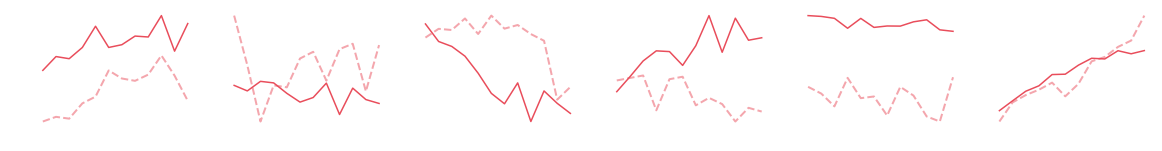

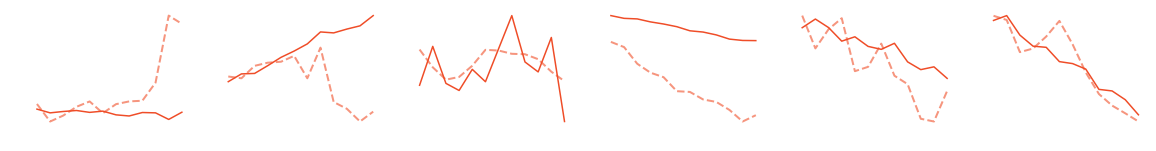

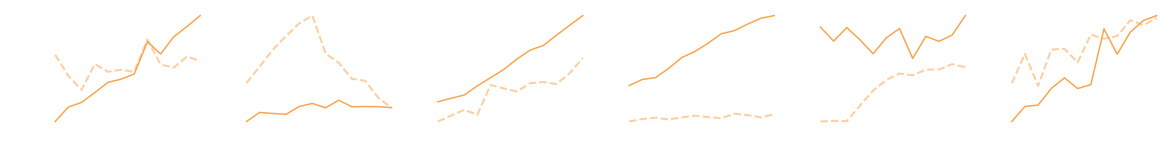

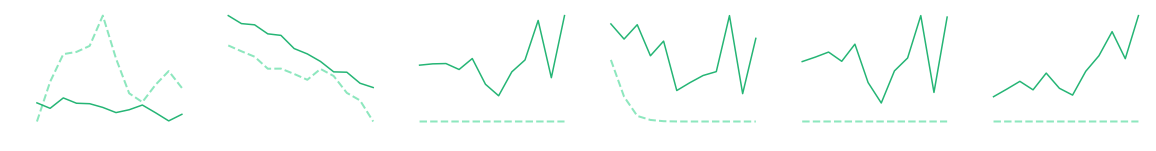

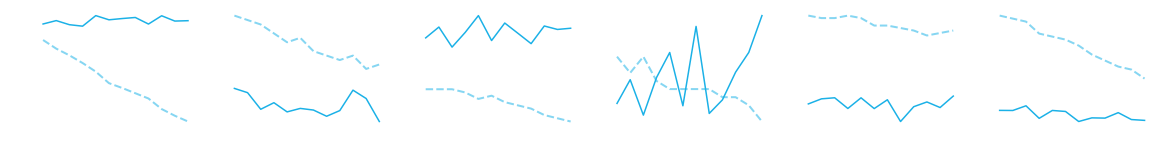

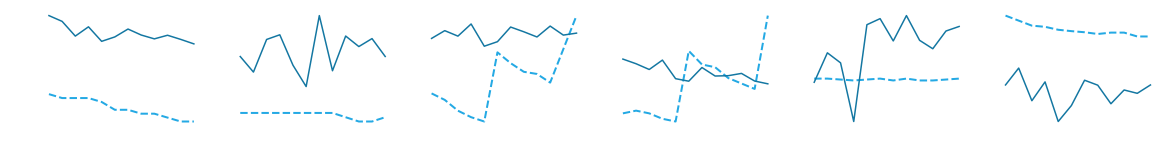

All fold vaildation were ended.
5-fold validation accuracy: 0.966


In [17]:
accuracies = []
for FOLD in range(N_FOLD):
    
    pred_input = pred_inputs[FOLD]
    pred_label = pred_labels[FOLD]
    
    rnn_input = rnn_inputs[FOLD]
    rnn_label = rnn_labels[FOLD]

    print("%d-fold started." % (FOLD+1))
    # Parameters
    EXPLANATION_F = EXPLANATION + "_F" + str(FOLD+1)
    LIMIT = 3002
    SHIELD = 1000
    
    global_step = tf.Variable(0, trainable=False)
    LEARNING_RATE = tf.train.exponential_decay(0.035, global_step, 3000, 0.96, staircase=True)
    EPSILON = 0.00001
    TRAINING_EPOCHS = 50000
    N_HIDDEN = 32
    N_FC_HIDDEN = 512
    DROP_PROB = 0.9
    BATCH_SIZE = 512
    DISPLAY_STEP = 500
    N_INPUT = pred_input.shape[2]
    N_OUTPUT = N_TASKS

    # tf Graph input
    x = tf.placeholder("float", [None, TIME_STEPS, N_INPUT])
    y = tf.placeholder("float", [None, OUTPUT_SIZE, N_OUTPUT])
    drop_prob = tf.placeholder("float")
    phase = tf.placeholder(tf.bool)
    
    # Define weights
    weights = tf.get_variable(EXPLANATION_F[-2:] + "wgt", shape=[N_HIDDEN, OUTPUT_SIZE], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(EXPLANATION_F[-2:] + "bias", shape=[OUTPUT_SIZE], initializer=tf.contrib.layers.xavier_initializer())
    variable_summaries(weights)
    variable_summaries(biases)    
    
    
    def RNN(x, weights, biases, drop_prob):

        x = tf.unstack(x, TIME_STEPS, 1)

        cell = rnn.LayerNormBasicLSTMCell(N_HIDDEN, dropout_keep_prob=drop_prob, reuse=tf.AUTO_REUSE)
        outputs, states = rnn.static_rnn(cell, x, dtype=tf.float32)
        
        activation = tf.matmul(outputs[-1], weights) + biases

        return activation

    def Task_specific_FC(x, n_hidden, phase, tasknum):
        h1 = BN_FC(x, n_hidden, phase, "task" + str(tasknum) + "_layer1")
        h2 = BN_FC(h1, n_hidden, phase, "task" + str(tasknum) + "_layer2")
        
        return FC(h2, OUTPUT_SIZE, "task" + str(tasknum) + "_out")
    
    # Construct model
    shared_layer = RNN(x, weights, biases, DROP_PROB)
    pred_1 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 1)
    pred_2 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 2)
    pred_3 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 3)
    pred_4 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 4)
    pred_5 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 5)
    pred_6 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 6)
    pred = tf.stack([pred_1, pred_2, pred_3, pred_4, pred_5, pred_6], axis=2)
    # Define loss and optimizer
    cost_1 = tf.losses.mean_squared_error(labels=y[:, :, 0], predictions=pred_1)
    cost_2 = tf.losses.mean_squared_error(labels=y[:, :, 1], predictions=pred_2)
    cost_3 = tf.losses.mean_squared_error(labels=y[:, :, 2], predictions=pred_3)
    cost_4 = tf.losses.mean_squared_error(labels=y[:, :, 3], predictions=pred_4)
    cost_5 = tf.losses.mean_squared_error(labels=y[:, :, 4], predictions=pred_5)
    cost_6 = tf.losses.mean_squared_error(labels=y[:, :, 5], predictions=pred_6)
    joint_cost = cost_1 + cost_2 + cost_3 + cost_4 + cost_5 + cost_6
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    optimizer_ = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    with tf.control_dependencies(update_ops):
        op1 = optimizer_.minimize(cost_1, global_step=global_step)
        op2 = optimizer_.minimize(cost_2, global_step=global_step)
        op3 = optimizer_.minimize(cost_3, global_step=global_step)
        op4 = optimizer_.minimize(cost_4, global_step=global_step)
        op5 = optimizer_.minimize(cost_5, global_step=global_step)
        op6 = optimizer_.minimize(cost_6, global_step=global_step)
    tf.summary.scalar('cost', joint_cost)
    
    # Evaluate model
    total_error = tf.reduce_sum(tf.square(tf.subtract(tf.reshape(y, [-1, OUTPUT_SIZE*N_TASKS]), 
                                                      tf.reduce_mean(tf.reshape(y, [-1, OUTPUT_SIZE*N_TASKS])))))
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(tf.reshape(y, [-1, OUTPUT_SIZE*N_TASKS]),
                                                            tf.reshape(pred, [-1, OUTPUT_SIZE*N_TASKS]))))
    accuracy = tf.subtract(1., tf.divide(unexplained_error, total_error))
    tf.summary.scalar('accuracy', accuracy)
    
    # Initializing the variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    merged = tf.summary.merge_all()

    # Do some optimizations
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
    train_writer = tf.summary.FileWriter("./summary/train/" + "F"+ str(FOLD+1), sess.graph)
    test_writer = tf.summary.FileWriter("./summary/test/" + "F"+ str(FOLD+1))
    sess.run(init)

    # Launch the graph
    best_pred_acc = EX_PRED
    best_pred_cost = 100000
    ex_pred_acc = 0
    ex_pred_cost = 100000
    early_stop_buffer = 0
    # Keep training until reach max iterations
    start = time.time()

    for EPOCH in range(TRAINING_EPOCHS):

        batch_x, batch_y = resample(rnn_input, rnn_label, n_samples = BATCH_SIZE, replace = False)
        cost_, summary, = sess.run([joint_cost, merged], feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1})
        op_set = [sess.run(op1, feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1}),
                  sess.run(op2, feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1}),
                  sess.run(op3, feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1}),
                  sess.run(op4, feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1}),
                  sess.run(op5, feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1}),
                  sess.run(op6, feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1})]
        op_selector = int((N_TASKS)*np.random.rand())
        op_set[op_selector]
        train_writer.add_summary(summary, EPOCH)
        summary, pred_acc, pred_cost = sess.run([merged, accuracy, joint_cost],
                                                feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
        
        test_writer.add_summary(summary, EPOCH)

        
        if pred_cost < ex_pred_cost:
            if EPOCH <= SHIELD:
                pass
            elif pred_cost < best_pred_cost:
                bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
                save_path = saver.save(sess, bestpath)
                best_pred_cost = pred_cost
                early_stop_buffer = 0
                print ("Epoch: %8d/%8d cost: %.6f, best: %.3f *Best value was replaced." % (EPOCH+1, TRAINING_EPOCHS, cost_, best_pred_cost))
                for i in range(N_TASKS):
                    print("%.3f"% r2_score(pred_label[:,:,i], R2[:,:,i]), end=" ")
                print("")
                print(r2_score(pred_label.reshape(-1, OUTPUT_SIZE*N_TASKS), R2.reshape(-1, OUTPUT_SIZE*N_TASKS)))
        else:
            early_stop_buffer += 1

            
        if early_stop_buffer >= LIMIT:
            print ("\nEarly stopping.")
            break
        
        ex_pred_cost = pred_cost        
        if EPOCH % DISPLAY_STEP == 0:
            print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH, TRAINING_EPOCHS, cost_, best_pred_cost))
            train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0, phase: 0})
            R2, pred_acc = sess.run([pred, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
            print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc, pred_acc))
            for i in range(N_TASKS):
                print("%.3f"% r2_score(pred_label[:,:,i], R2[:,:,i]), end=" ")
            print("")
            print(r2_score(pred_label.reshape(-1, OUTPUT_SIZE*N_TASKS), R2.reshape(-1, OUTPUT_SIZE*N_TASKS)))


    print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH+1, TRAINING_EPOCHS, cost_, best_pred_cost))
    train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0, phase: 0})
    pred_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
    print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc,pred_acc))

    end = time.time() - start
    print ("Optimization Finished\ntraining time: %.2f sec." % (end))
    
    
    #Choose best model
    bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
    saver.restore(sess, bestpath)
    final_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
    accuracies.append(final_acc)
    print ("Test accuracy:", final_acc)
    
    #Result visualizing
    prediction = sess.run(pred, feed_dict={x: pred_input, drop_prob: 1.0, phase: 0})
    print("Chronological graphs for fold # %d." % (FOLD+1))
    x_t = np.arange(0, OUTPUT_SIZE)

    prediction_csv = []
    pred_label_csv = []
    for _ in range(N_TASKS):
        
        NUMBERS = np.arange(1, prediction.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 661

        for NUMBER in NUMBERS:
            fig = plt.subplot(position)
            measured1 = plt.plot(x_t, pred_label[NUMBER, :, _], "--", linewidth=2, c=cmap_m[_])
            expect1 = plt.plot(x_t, prediction[NUMBER, :, _], c=cmap[_])
            fig.axis('off')

            position += 1
        plt.show()
        
        temp1 = (prediction[:, :, _] * (LABELMAXS[_] - LABELMINS[_])) + LABELMINS[_]
        temp2 = (pred_label[:, :, _] * (LABELMAXS[_] - LABELMINS[_])) + LABELMINS[_]
        prediction_csv.append(pd.DataFrame(temp1, index=pred_label_index[FOLD]))
        pred_label_csv.append(pd.DataFrame(temp2, index=pred_label_index[FOLD]))
    
    if not os.path.isdir("./results/"):
        os.makedirs("./results/")
    pd.concat(prediction_csv, axis=1).to_csv("./results/" + "output_" + EXPLANATION_F + ".CSV")
    pd.concat(pred_label_csv, axis=1).to_csv("./results/" + "labels_" + EXPLANATION_F + ".CSV")
    
    tf.reset_default_graph()
    sess.close()
    
print("All fold vaildation were ended.")
print("%d-fold validation accuracy: %.3f" % (N_FOLD, sum(accuracies)/N_FOLD))